## What's this TensorFlow business?

You've written a lot of code in this assignment to provide a whole host of neural network functionality. Dropout, Batch Norm, and 2D convolutions are some of the workhorses of deep learning in computer vision. You've also worked hard to make your code efficient and vectorized.

For the last part of this assignment, though, we're going to leave behind your beautiful codebase and instead migrate to one of two popular deep learning frameworks: in this instance, TensorFlow (or PyTorch, if you switch over to that notebook)

#### What is it?
TensorFlow is a system for executing computational graphs over Tensor objects, with native support for performing backpropogation for its Variables. In it, we work with Tensors which are n-dimensional arrays analogous to the numpy ndarray.

#### Why?

* Our code will now run on GPUs! Much faster training. Writing your own modules to run on GPUs is beyond the scope of this class, unfortunately.
* We want you to be ready to use one of these frameworks for your project so you can experiment more efficiently than if you were writing every feature you want to use by hand. 
* We want you to stand on the shoulders of giants! TensorFlow and PyTorch are both excellent frameworks that will make your lives a lot easier, and now that you understand their guts, you are free to use them :) 
* We want you to be exposed to the sort of deep learning code you might run into in academia or industry. 

## How will I learn TensorFlow?

TensorFlow has many excellent tutorials available, including those from [Google themselves](https://www.tensorflow.org/get_started/get_started).

Otherwise, this notebook will walk you through much of what you need to do to train models in TensorFlow. See the end of the notebook for some links to helpful tutorials if you want to learn more or need further clarification on topics that aren't fully explained here.

## Load Datasets


In [1]:
import tensorflow as tf
import numpy as np
import math
import timeit
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from cs231n.data_utils import load_CIFAR10

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=10000):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the two-layer neural net classifier. These are the same steps as
    we used for the SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

    # Subsample the data
    mask = range(num_training, num_training + num_validation)
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = range(num_training)
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = range(num_test)
    X_test = X_test[mask]
    y_test = y_test[mask]

    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis=0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image

    return X_train, y_train, X_val, y_val, X_test, y_test


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


## Example Model

### Some useful utilities

. Remember that our image data is initially N x H x W x C, where:
* N is the number of datapoints
* H is the height of each image in pixels
* W is the height of each image in pixels
* C is the number of channels (usually 3: R, G, B)

This is the right way to represent the data when we are doing something like a 2D convolution, which needs spatial understanding of where the pixels are relative to each other. When we input image data into fully connected affine layers, however, we want each data example to be represented by a single vector -- it's no longer useful to segregate the different channels, rows, and columns of the data.

TensorFlow supports many other layer types, loss functions, and optimizers - you will experiment with these next. Here's the official API documentation for these (if any of the parameters used above were unclear, this resource will also be helpful). 

* Layers, Activations, Loss functions : https://www.tensorflow.org/api_guides/python/nn
* Optimizers: https://www.tensorflow.org/api_guides/python/train#Optimizers
* BatchNorm: https://www.tensorflow.org/api_docs/python/tf/contrib/layers/batch_norm

In [3]:
def run_model(session, predict, loss_val, Xd, yd,
              epochs=1, batch_size=64, print_every=100,
              training=None, plot_losses=False):
    # have tensorflow compute accuracy
    correct_prediction = tf.equal(tf.argmax(predict,1), y)
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    # shuffle indicies
    train_indicies = np.arange(Xd.shape[0])
    np.random.shuffle(train_indicies)

    training_now = training is not None
    
    # setting up variables we want to compute (and optimizing)
    # if we have a training function, add that to things we compute
    variables = [mean_loss,correct_prediction,accuracy]
    if training_now:
        variables[-1] = training
    
    # counter 
    iter_cnt = 0
    for e in range(epochs):
        # keep track of losses and accuracy
        correct = 0
        losses = []
        # make sure we iterate over the dataset once
        for i in range(int(math.ceil(Xd.shape[0]/batch_size))):
            # generate indicies for the batch
            start_idx = (i*batch_size)%X_train.shape[0]
            idx = train_indicies[start_idx:start_idx+batch_size]
            
            # create a feed dictionary for this batch
            feed_dict = {X: Xd[idx,:],
                         y: yd[idx],
                         is_training: training_now }
            # get batch size
            actual_batch_size = yd[i:i+batch_size].shape[0]
            
            # have tensorflow compute loss and correct predictions
            # and (if given) perform a training step
            loss, corr, _ = session.run(variables,feed_dict=feed_dict)
            
            # aggregate performance stats
            losses.append(loss*actual_batch_size)
            correct += np.sum(corr)
            
            # print every now and then
            if training_now and (iter_cnt % print_every) == 0:
                print("Iteration {0}: with minibatch training loss = {1:.3g} and accuracy of {2:.2g}"\
                      .format(iter_cnt,loss,1.0*np.sum(corr)/actual_batch_size))
            iter_cnt += 1
        total_correct = 1.0*correct/Xd.shape[0]
        total_loss = np.sum(losses)/Xd.shape[0]
        print("Epoch {2}, Overall loss = {0:.3g} and accuracy of {1:.3g}"\
              .format(total_loss,total_correct,e+1))
        if plot_losses:
            plt.plot(losses)
            plt.grid(True)
            plt.title('Epoch {} Loss'.format(e+1))
            plt.xlabel('minibatch number')
            plt.ylabel('minibatch loss')
            plt.show()
    return total_loss,total_correct

## Train a _great_ model on CIFAR-10!

Now it's your job to experiment with architectures, hyperparameters, loss functions, and optimizers to train a model that achieves ** >= 70% accuracy on the validation set** of CIFAR-10. You can use the `run_model` function from above.

### Things you should try:
- **Filter size**: Above we used 7x7; this makes pretty pictures but smaller filters may be more efficient
- **Number of filters**: Above we used 32 filters. Do more or fewer do better?
- **Pooling vs Strided Convolution**: Do you use max pooling or just stride convolutions?
- **Batch normalization**: Try adding spatial batch normalization after convolution layers and vanilla batch normalization after affine layers. Do your networks train faster?
- **Network architecture**: The network above has two layers of trainable parameters. Can you do better with a deep network? Good architectures to try include:
    - [conv-relu-pool]xN -> [affine]xM -> [softmax or SVM]
    - [conv-relu-conv-relu-pool]xN -> [affine]xM -> [softmax or SVM]
    - [batchnorm-relu-conv]xN -> [affine]xM -> [softmax or SVM]
- **Use TensorFlow Scope**: Use TensorFlow scope and/or [tf.layers](https://www.tensorflow.org/api_docs/python/tf/layers) to make it easier to write deeper networks. See [this tutorial](https://www.tensorflow.org/tutorials/layers) for making how to use `tf.layers`. 
- **Use Learning Rate Decay**: [As the notes point out](http://cs231n.github.io/neural-networks-3/#anneal), decaying the learning rate might help the model converge. Feel free to decay every epoch, when loss doesn't change over an entire epoch, or any other heuristic you find appropriate. See the [Tensorflow documentation](https://www.tensorflow.org/versions/master/api_guides/python/train#Decaying_the_learning_rate) for learning rate decay.
- **Global Average Pooling**: Instead of flattening and then having multiple affine layers, perform convolutions until your image gets small (7x7 or so) and then perform an average pooling operation to get to a 1x1 image picture (1, 1 , Filter#), which is then reshaped into a (Filter#) vector. This is used in [Google's Inception Network](https://arxiv.org/abs/1512.00567) (See Table 1 for their architecture).
- **Regularization**: Add l2 weight regularization, or perhaps use [Dropout as in the TensorFlow MNIST tutorial](https://www.tensorflow.org/get_started/mnist/pros)

### Tips for training
For each network architecture that you try, you should tune the learning rate and regularization strength. When doing this there are a couple important things to keep in mind:

- If the parameters are working well, you should see improvement within a few hundred iterations
- Remember the coarse-to-fine approach for hyperparameter tuning: start by testing a large range of hyperparameters for just a few training iterations to find the combinations of parameters that are working at all.
- Once you have found some sets of parameters that seem to work, search more finely around these parameters. You may need to train for more epochs.
- You should use the validation set for hyperparameter search, and we'll save the test set for evaluating your architecture on the best parameters as selected by the validation set.

### Going above and beyond
If you are feeling adventurous there are many other features you can implement to try and improve your performance. You are **not required** to implement any of these; however they would be good things to try for extra credit.

- Alternative update steps: For the assignment we implemented SGD+momentum, RMSprop, and Adam; you could try alternatives like AdaGrad or AdaDelta.
- Alternative activation functions such as leaky ReLU, parametric ReLU, ELU, or MaxOut.
- Model ensembles
- Data augmentation
- New Architectures
  - [ResNets](https://arxiv.org/abs/1512.03385) where the input from the previous layer is added to the output.
  - [DenseNets](https://arxiv.org/abs/1608.06993) where inputs into previous layers are concatenated together.
  - [This blog has an in-depth overview](https://chatbotslife.com/resnets-highwaynets-and-densenets-oh-my-9bb15918ee32)

If you do decide to implement something extra, clearly describe it in the "Extra Credit Description" cell below.

### What we expect
At the very least, you should be able to train a ConvNet that gets at **>= 70% accuracy on the validation set**. This is just a lower bound - if you are careful it should be possible to get accuracies much higher than that! Extra credit points will be awarded for particularly high-scoring models or unique approaches.

You should use the space below to experiment and train your network. The final cell in this notebook should contain the training and validation set accuracies for your final trained network.

Have fun and happy training!

In [4]:
# Feel free to play with this cell

# [conv-relu-pool]xN -> [affine]xM -> [softmax or SVM]
# [conv-relu-conv-relu-pool]xN -> [affine]xM -> [softmax or SVM]
# [batchnorm-relu-conv]xN -> [affine]xM -> [softmax or SVM]
def my_model(X,y,is_training):
    y1 = tf.layers.conv2d(X, filters=64, kernel_size=[5, 5], strides=[1, 1], padding='same', activation=tf.nn.relu)
    y1 = tf.layers.max_pooling2d(y1, pool_size=[3, 3], strides=[2, 2])
    y1 = tf.layers.batch_normalization(y1, epsilon=1e-7, training=is_training)

    y2 = tf.layers.conv2d(y1, filters=64, kernel_size=[5, 5], strides=[1, 1], padding='same', activation=tf.nn.relu)
    y2 = tf.layers.max_pooling2d(y2, pool_size=[3, 3], strides=[2, 2])
    y2 = tf.layers.batch_normalization(y2, epsilon=1e-7, training=is_training)

    y3 = tf.layers.conv2d(y2, filters=128, kernel_size=[5, 5], strides=[1, 1], padding='same', activation=tf.nn.relu)
    y3 = tf.layers.max_pooling2d(y3, pool_size=[3, 3], strides=[2, 2])
    y3 = tf.layers.batch_normalization(y3, epsilon=1e-7, training=is_training)

    mp_vector = tf.contrib.layers.flatten(y3)
    y4 = tf.layers.dense(mp_vector, units=384, activation=tf.nn.relu)
    y5 = tf.layers.dense(y4, units=96, activation=tf.nn.relu)
    y_out = tf.layers.dense(y5, 10)
    return y_out

tf.reset_default_graph()

X = tf.placeholder(tf.float32, [None, 32, 32, 3])
y = tf.placeholder(tf.int64, [None])
is_training = tf.placeholder(tf.bool)

y_out = my_model(X, y, is_training)

mean_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=tf.one_hot(y, 10), logits=y_out))
optimizer = tf.train.RMSPropOptimizer(1e-3)

# batch normalization in tensorflow requires this extra dependency
extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(extra_update_ops):
    train_step = optimizer.minimize(mean_loss)

In [5]:
# Now we're going to feed a random batch into the model 
# and make sure the output is the right size
x = np.random.randn(64, 32, 32,3)
with tf.Session() as sess:
    with tf.device("/cpu:0"): #"/cpu:0" or "/gpu:0"
        tf.global_variables_initializer().run()

        ans = sess.run(y_out,feed_dict={X:x,is_training:True})
        %timeit sess.run(y_out,feed_dict={X:x,is_training:True})
        print(ans.shape)
        print(np.array_equal(ans.shape, np.array([64, 10])))

10 loops, best of 3: 82.9 ms per loop
(64, 10)
True


Training
Iteration 0: with minibatch training loss = 2.74 and accuracy of 0.14
Iteration 200: with minibatch training loss = 1.43 and accuracy of 0.47
Iteration 400: with minibatch training loss = 1.18 and accuracy of 0.56
Iteration 600: with minibatch training loss = 1.06 and accuracy of 0.59
Epoch 1, Overall loss = 1.34 and accuracy of 0.527


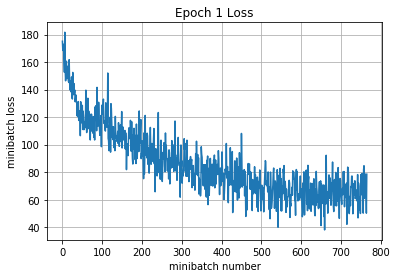

Iteration 800: with minibatch training loss = 1.06 and accuracy of 0.56
Iteration 1000: with minibatch training loss = 0.963 and accuracy of 0.7
Iteration 1200: with minibatch training loss = 1.07 and accuracy of 0.64
Iteration 1400: with minibatch training loss = 0.602 and accuracy of 0.8
Epoch 2, Overall loss = 0.82 and accuracy of 0.714


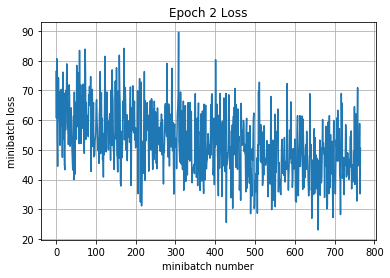

Iteration 1600: with minibatch training loss = 0.97 and accuracy of 0.64
Iteration 1800: with minibatch training loss = 0.692 and accuracy of 0.7
Iteration 2000: with minibatch training loss = 0.8 and accuracy of 0.75
Iteration 2200: with minibatch training loss = 0.495 and accuracy of 0.86
Epoch 3, Overall loss = 0.616 and accuracy of 0.788


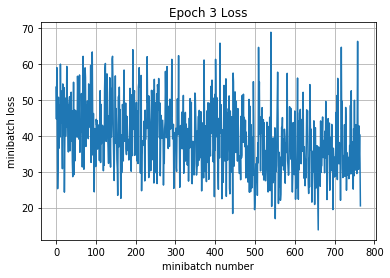

Iteration 2400: with minibatch training loss = 0.533 and accuracy of 0.84
Iteration 2600: with minibatch training loss = 0.386 and accuracy of 0.86
Iteration 2800: with minibatch training loss = 0.436 and accuracy of 0.8
Iteration 3000: with minibatch training loss = 0.267 and accuracy of 0.92
Epoch 4, Overall loss = 0.468 and accuracy of 0.84


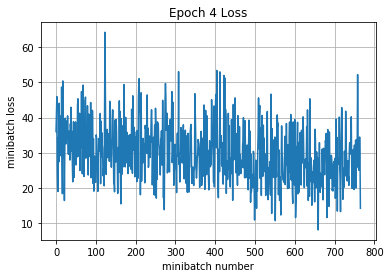

Iteration 3200: with minibatch training loss = 0.335 and accuracy of 0.88
Iteration 3400: with minibatch training loss = 0.342 and accuracy of 0.89
Iteration 3600: with minibatch training loss = 0.27 and accuracy of 0.91
Iteration 3800: with minibatch training loss = 0.133 and accuracy of 0.92
Epoch 5, Overall loss = 0.363 and accuracy of 0.873


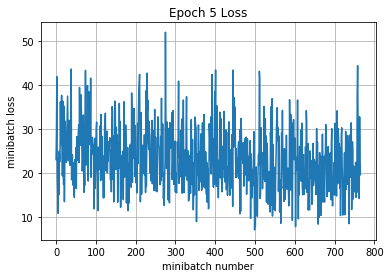

Iteration 4000: with minibatch training loss = 0.203 and accuracy of 0.91
Iteration 4200: with minibatch training loss = 0.229 and accuracy of 0.91
Iteration 4400: with minibatch training loss = 0.229 and accuracy of 0.89
Epoch 6, Overall loss = 0.288 and accuracy of 0.9


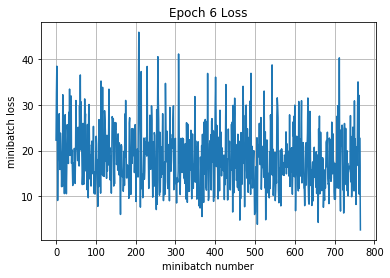

Iteration 4600: with minibatch training loss = 0.172 and accuracy of 0.94
Iteration 4800: with minibatch training loss = 0.131 and accuracy of 0.94
Iteration 5000: with minibatch training loss = 0.216 and accuracy of 0.91
Iteration 5200: with minibatch training loss = 0.215 and accuracy of 0.89
Epoch 7, Overall loss = 0.234 and accuracy of 0.919


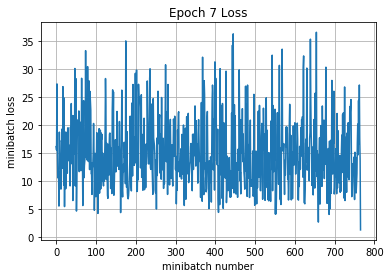

Iteration 5400: with minibatch training loss = 0.457 and accuracy of 0.89
Iteration 5600: with minibatch training loss = 0.199 and accuracy of 0.97
Iteration 5800: with minibatch training loss = 0.267 and accuracy of 0.92
Iteration 6000: with minibatch training loss = 0.191 and accuracy of 0.91
Epoch 8, Overall loss = 0.205 and accuracy of 0.93


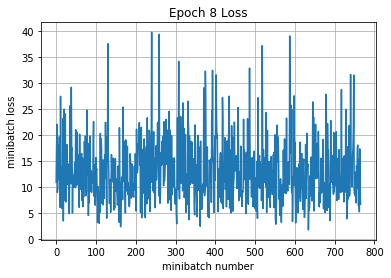

Iteration 6200: with minibatch training loss = 0.427 and accuracy of 0.89
Iteration 6400: with minibatch training loss = 0.0751 and accuracy of 0.97
Iteration 6600: with minibatch training loss = 0.156 and accuracy of 0.95
Iteration 6800: with minibatch training loss = 0.139 and accuracy of 0.98
Epoch 9, Overall loss = 0.183 and accuracy of 0.939


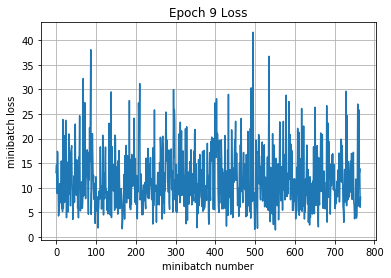

Iteration 7000: with minibatch training loss = 0.207 and accuracy of 0.95
Iteration 7200: with minibatch training loss = 0.123 and accuracy of 0.94
Iteration 7400: with minibatch training loss = 0.187 and accuracy of 0.94
Iteration 7600: with minibatch training loss = 0.0995 and accuracy of 0.94
Epoch 10, Overall loss = 0.161 and accuracy of 0.947


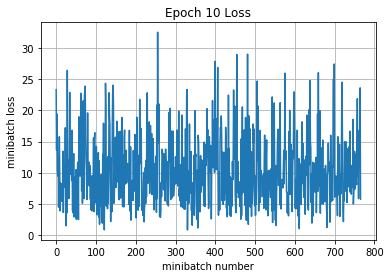

Iteration 7800: with minibatch training loss = 0.0562 and accuracy of 0.98
Iteration 8000: with minibatch training loss = 0.0392 and accuracy of 1
Iteration 8200: with minibatch training loss = 0.327 and accuracy of 0.91
Iteration 8400: with minibatch training loss = 0.2 and accuracy of 0.92
Epoch 11, Overall loss = 0.147 and accuracy of 0.952


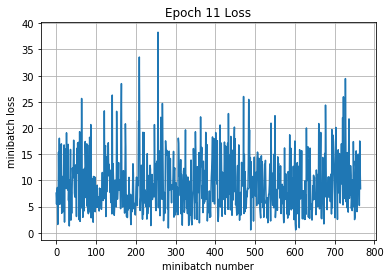

Iteration 8600: with minibatch training loss = 0.124 and accuracy of 0.97
Iteration 8800: with minibatch training loss = 0.069 and accuracy of 0.98
Iteration 9000: with minibatch training loss = 0.162 and accuracy of 0.95
Epoch 12, Overall loss = 0.136 and accuracy of 0.957


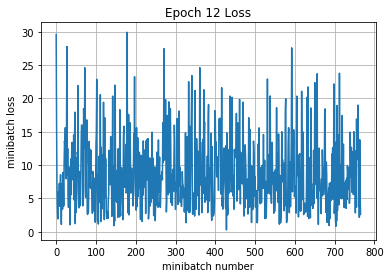

Iteration 9200: with minibatch training loss = 0.0827 and accuracy of 0.97
Iteration 9400: with minibatch training loss = 0.175 and accuracy of 0.94
Iteration 9600: with minibatch training loss = 0.0781 and accuracy of 0.98
Iteration 9800: with minibatch training loss = 0.0668 and accuracy of 0.97
Epoch 13, Overall loss = 0.128 and accuracy of 0.959


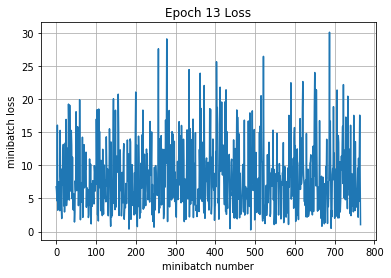

Iteration 10000: with minibatch training loss = 0.0519 and accuracy of 0.98
Iteration 10200: with minibatch training loss = 0.0655 and accuracy of 0.98
Iteration 10400: with minibatch training loss = 0.068 and accuracy of 0.98
Iteration 10600: with minibatch training loss = 0.0348 and accuracy of 0.98
Epoch 14, Overall loss = 0.122 and accuracy of 0.962


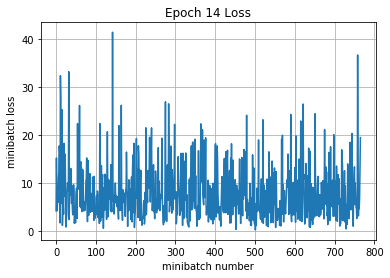

Iteration 10800: with minibatch training loss = 0.0748 and accuracy of 0.98
Iteration 11000: with minibatch training loss = 0.114 and accuracy of 0.95
Iteration 11200: with minibatch training loss = 0.179 and accuracy of 0.97
Iteration 11400: with minibatch training loss = 0.0534 and accuracy of 0.98
Epoch 15, Overall loss = 0.114 and accuracy of 0.965


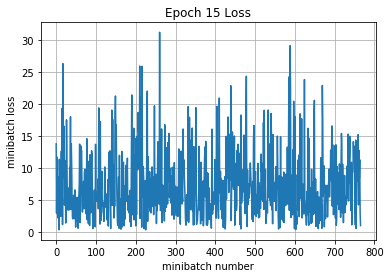

Iteration 11600: with minibatch training loss = 0.0895 and accuracy of 0.97
Iteration 11800: with minibatch training loss = 0.0708 and accuracy of 0.97
Iteration 12000: with minibatch training loss = 0.0534 and accuracy of 0.97
Iteration 12200: with minibatch training loss = 0.149 and accuracy of 0.97
Epoch 16, Overall loss = 0.112 and accuracy of 0.967


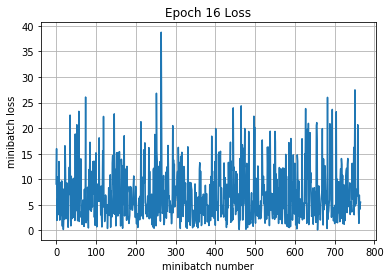

Iteration 12400: with minibatch training loss = 0.0202 and accuracy of 0.98
Iteration 12600: with minibatch training loss = 0.0384 and accuracy of 0.98
Iteration 12800: with minibatch training loss = 0.0458 and accuracy of 0.97
Iteration 13000: with minibatch training loss = 0.115 and accuracy of 0.95
Epoch 17, Overall loss = 0.102 and accuracy of 0.97


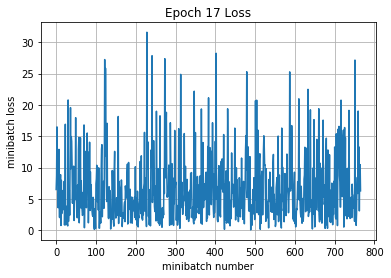

Iteration 13200: with minibatch training loss = 0.0376 and accuracy of 1
Iteration 13400: with minibatch training loss = 0.136 and accuracy of 0.95
Iteration 13600: with minibatch training loss = 0.0227 and accuracy of 0.98
Epoch 18, Overall loss = 0.0998 and accuracy of 0.97


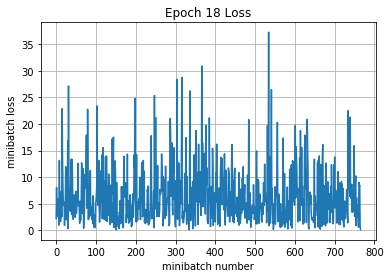

Iteration 13800: with minibatch training loss = 0.149 and accuracy of 0.97
Iteration 14000: with minibatch training loss = 0.0163 and accuracy of 1
Iteration 14200: with minibatch training loss = 0.157 and accuracy of 0.97
Iteration 14400: with minibatch training loss = 0.0384 and accuracy of 0.98
Epoch 19, Overall loss = 0.0987 and accuracy of 0.972


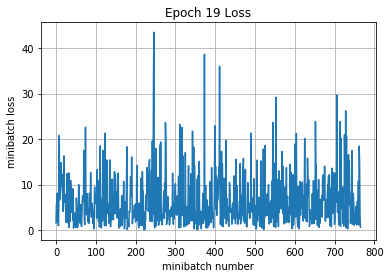

Iteration 14600: with minibatch training loss = 0.0559 and accuracy of 0.98
Iteration 14800: with minibatch training loss = 0.154 and accuracy of 0.95
Iteration 15000: with minibatch training loss = 0.0586 and accuracy of 0.95
Iteration 15200: with minibatch training loss = 0.205 and accuracy of 0.91
Epoch 20, Overall loss = 0.0958 and accuracy of 0.972


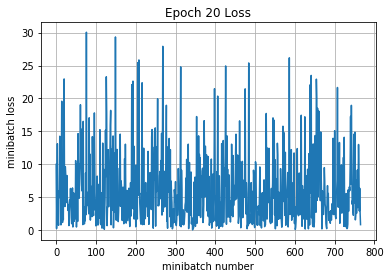

Iteration 15400: with minibatch training loss = 0.0105 and accuracy of 1
Iteration 15600: with minibatch training loss = 0.044 and accuracy of 0.98
Iteration 15800: with minibatch training loss = 0.122 and accuracy of 0.95
Iteration 16000: with minibatch training loss = 0.109 and accuracy of 0.97
Epoch 21, Overall loss = 0.0962 and accuracy of 0.973


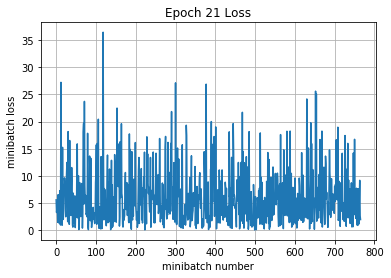

Iteration 16200: with minibatch training loss = 0.0867 and accuracy of 0.97
Iteration 16400: with minibatch training loss = 0.197 and accuracy of 0.98
Iteration 16600: with minibatch training loss = 0.442 and accuracy of 0.94
Iteration 16800: with minibatch training loss = 0.078 and accuracy of 0.97
Epoch 22, Overall loss = 0.089 and accuracy of 0.975


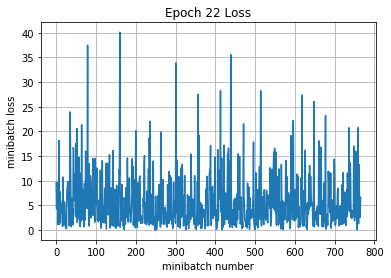

Iteration 17000: with minibatch training loss = 0.159 and accuracy of 0.98
Iteration 17200: with minibatch training loss = 0.0271 and accuracy of 0.98
Iteration 17400: with minibatch training loss = 0.0126 and accuracy of 1
Iteration 17600: with minibatch training loss = 0.00619 and accuracy of 1
Epoch 23, Overall loss = 0.0932 and accuracy of 0.974


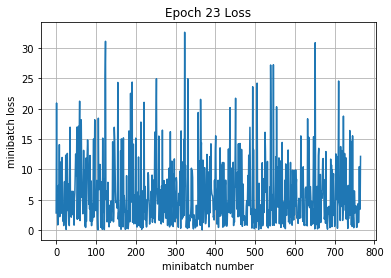

Iteration 17800: with minibatch training loss = 0.0195 and accuracy of 0.98
Iteration 18000: with minibatch training loss = 0.0283 and accuracy of 0.98
Iteration 18200: with minibatch training loss = 0.111 and accuracy of 0.98
Epoch 24, Overall loss = 0.0831 and accuracy of 0.976


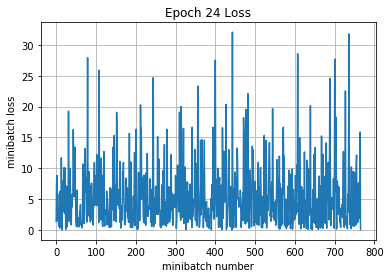

Iteration 18400: with minibatch training loss = 0.0142 and accuracy of 1
Iteration 18600: with minibatch training loss = 0.13 and accuracy of 0.97
Iteration 18800: with minibatch training loss = 0.182 and accuracy of 0.94
Iteration 19000: with minibatch training loss = 0.128 and accuracy of 0.98
Epoch 25, Overall loss = 0.0875 and accuracy of 0.977


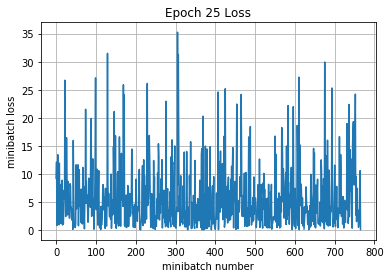

Iteration 19200: with minibatch training loss = 0.212 and accuracy of 0.98
Iteration 19400: with minibatch training loss = 0.0605 and accuracy of 0.97
Iteration 19600: with minibatch training loss = 0.0171 and accuracy of 0.98
Iteration 19800: with minibatch training loss = 0.221 and accuracy of 0.97
Epoch 26, Overall loss = 0.0832 and accuracy of 0.977


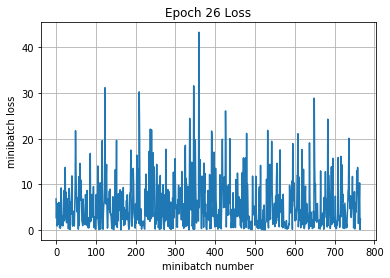

Iteration 20000: with minibatch training loss = 0.247 and accuracy of 0.97
Iteration 20200: with minibatch training loss = 0.141 and accuracy of 0.94
Iteration 20400: with minibatch training loss = 0.0293 and accuracy of 0.98
Iteration 20600: with minibatch training loss = 0.103 and accuracy of 0.95
Epoch 27, Overall loss = 0.0826 and accuracy of 0.978


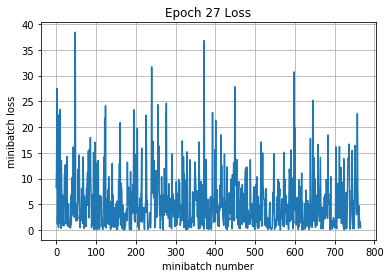

Iteration 20800: with minibatch training loss = 0.00108 and accuracy of 1
Iteration 21000: with minibatch training loss = 0.149 and accuracy of 0.95
Iteration 21200: with minibatch training loss = 0.113 and accuracy of 0.97
Iteration 21400: with minibatch training loss = 0.192 and accuracy of 0.95
Epoch 28, Overall loss = 0.0801 and accuracy of 0.979


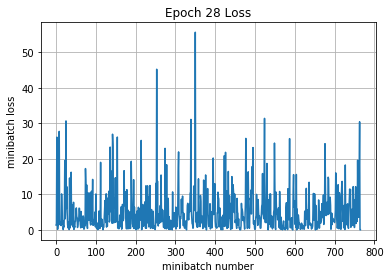

Iteration 21600: with minibatch training loss = 0.446 and accuracy of 0.95
Iteration 21800: with minibatch training loss = 0.116 and accuracy of 0.98
Iteration 22000: with minibatch training loss = 0.00448 and accuracy of 1
Iteration 22200: with minibatch training loss = 0.128 and accuracy of 0.97
Epoch 29, Overall loss = 0.0765 and accuracy of 0.981


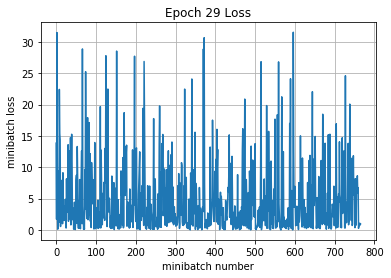

Iteration 22400: with minibatch training loss = 0.0111 and accuracy of 1
Iteration 22600: with minibatch training loss = 0.0213 and accuracy of 0.98
Iteration 22800: with minibatch training loss = 0.0109 and accuracy of 1
Epoch 30, Overall loss = 0.0726 and accuracy of 0.981


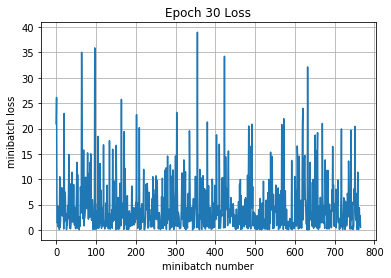

Validation
Epoch 1, Overall loss = 2.12 and accuracy of 0.788


(2.1232516403198241, 0.78800000000000003)

In [6]:
# Feel free to play with this cell
# This default code creates a session
# and trains your model for 10 epochs
# then prints the validation set accuracy
sess = tf.Session()

sess.run(tf.global_variables_initializer())
print('Training')
run_model(sess,y_out,mean_loss,X_train,y_train,30,64,200,train_step,True)
print('Validation')
run_model(sess,y_out,mean_loss,X_val,y_val,1,64)

In [7]:
# Test your model here, and make sure 
# the output of this cell is the accuracy
# of your best model on the training and val sets
# We're looking for >= 70% accuracy on Validation
print('Training')
run_model(sess,y_out,mean_loss,X_train,y_train,1,64)
print('Validation')
run_model(sess,y_out,mean_loss,X_val,y_val,1,64)

Training
Epoch 1, Overall loss = 0.139 and accuracy of 0.967
Validation
Epoch 1, Overall loss = 2.14 and accuracy of 0.788


(2.1356711044311525, 0.78800000000000003)

### Describe what you did here
In this cell you should also write an explanation of what you did, any additional features that you implemented, and any visualizations or graphs that you make in the process of training and evaluating your network

_Tell us here_

### Test Set - Do this only once
Now that we've gotten a result that we're happy with, we test our final model on the test set. This would be the score we would achieve on a competition. Think about how this compares to your validation set accuracy.

In [8]:
print('Test')
run_model(sess,y_out,mean_loss,X_test,y_test,1,64)

Test
Epoch 1, Overall loss = 2.49 and accuracy of 0.774


(2.4896766586303709, 0.77359999999999995)

## Going further with TensorFlow

The next assignment will make heavy use of TensorFlow. You might also find it useful for your projects. 


# Extra Credit Description
If you implement any additional features for extra credit, clearly describe them here with pointers to any code in this or other files if applicable.